In [1]:


import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")


In [7]:
CSV_PATH = "US_Accidents_March23.csv" 


In [9]:

print("Loading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH, parse_dates=['Start_Time','End_Time','Weather_Timestamp'], low_memory=False)

Loading CSV: US_Accidents_March23.csv


In [11]:

print("Rows:", len(df))
print("Columns:", list(df.columns)[:40])


Rows: 6054876
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming']


In [13]:
keep = ['ID','Severity','Start_Time','Start_Lat','Start_Lng',
        'Weather_Timestamp','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)',
        'Wind_Direction','Wind_Speed(mph)','Precipitation(in)','Weather_Condition',
        'Roadway','Traffic_Signal','Street','Side','City','County','State','Timezone','Distance(mi)']


In [15]:

existing = [c for c in keep if c in df.columns]
df = df[existing].copy()

In [17]:

if 'Start_Lat' not in df.columns and 'Start_lat' in df.columns:
    df.rename(columns={'Start_lat':'Start_Lat'}, inplace=True)
if 'Start_Lng' not in df.columns and 'Start_lng' in df.columns:
    df.rename(columns={'Start_lng':'Start_Lng'}, inplace=True)


In [19]:

num_cols = [c for c in ['Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)'] if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')


In [21]:

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time']).reset_index(drop=True)


In [23]:

df['hour'] = df['Start_Time'].dt.hour
df['minute'] = df['Start_Time'].dt.minute
df['dayofweek'] = df['Start_Time'].dt.dayofweek    # 0=Mon
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['date'] = df['Start_Time'].dt.date



In [25]:

has_loc = df['Start_Lat'].notna() & df['Start_Lng'].notna()
print("Rows with valid location:", has_loc.sum())


Rows with valid location: 5389938


In [27]:
hourly = df.groupby('hour').size().reindex(range(24), fill_value=0).rename('accidents').reset_index()


if 'Weather_Condition' in df.columns:
    df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown').str.title().str.strip()
    weather_counts = df['Weather_Condition'].value_counts().reset_index().rename(columns={'index':'weather','Weather_Condition':'accidents'})
else:
    weather_counts = pd.DataFrame()


In [29]:
if 'Weather_Condition' in df.columns and 'Severity' in df.columns:
    by_weather_sev = df.groupby(['Weather_Condition'])['Severity'].agg(['count','mean']).sort_values('count', ascending=False).reset_index()
else:
    by_weather_sev = pd.DataFrame()



In [31]:
road_cols = [c for c in ['Roadway','Traffic_Signal','Side','Street'] if c in df.columns]
road_counts = {}
for c in road_cols:
    road_counts[c] = df[c].fillna('Unknown').value_counts().head(20)


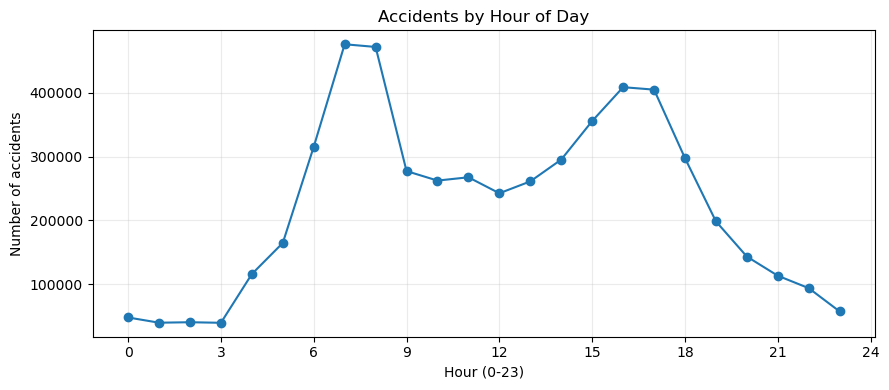

In [33]:

plt.figure(figsize=(9,4))
plt.plot(hourly['hour'], hourly['accidents'], marker='o')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Number of accidents")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


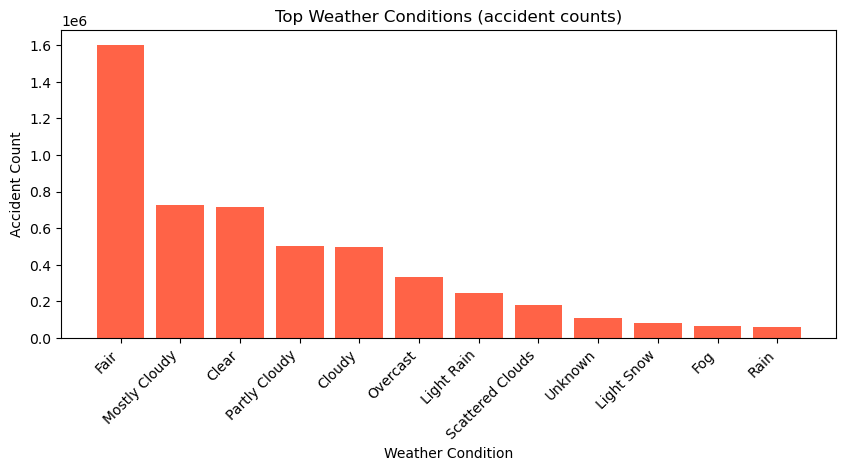

In [37]:

top_weather = df['Weather_Condition'].value_counts().head(12)

plt.figure(figsize=(10,4))
plt.bar(top_weather.index, top_weather.values, color="tomato")
plt.xticks(rotation=45, ha='right')
plt.title("Top Weather Conditions (accident counts)")
plt.xlabel("Weather Condition")
plt.ylabel("Accident Count")
plt.show()


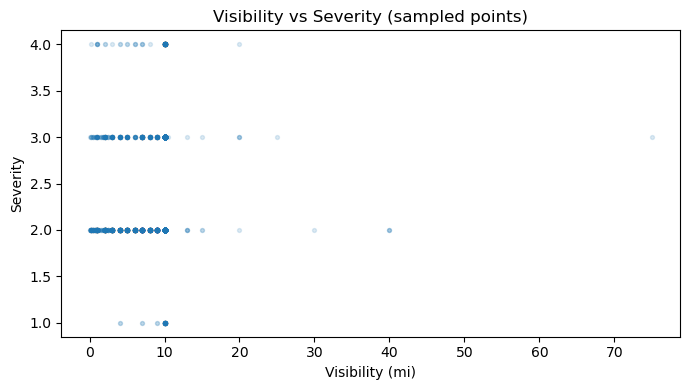

In [39]:
if 'Visibility(mi)' in df.columns and 'Severity' in df.columns:
    plt.figure(figsize=(7,4))
    subset = df.dropna(subset=['Visibility(mi)','Severity']).sample(min(5000, len(df)))
    plt.scatter(subset['Visibility(mi)'], subset['Severity'], alpha=0.15, s=8)
    plt.xlabel('Visibility (mi)')
    plt.ylabel('Severity')
    plt.title('Visibility vs Severity (sampled points)')
    plt.tight_layout()
    plt.show()


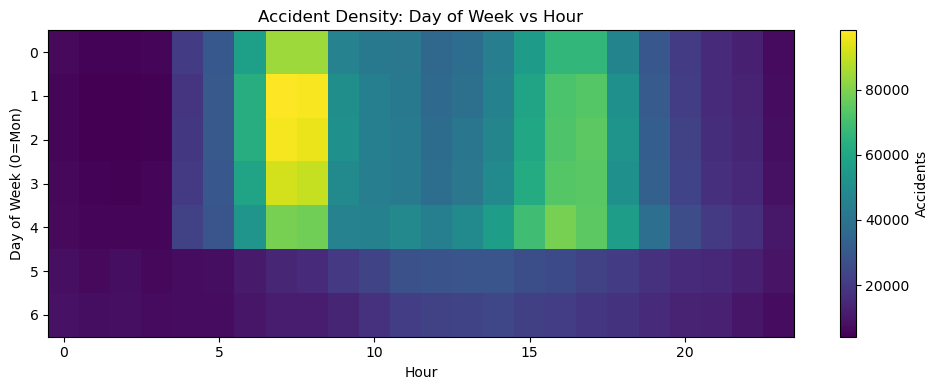

In [41]:

pivot = df.pivot_table(index='dayofweek', columns='hour', values='ID', aggfunc='count').fillna(0)
plt.figure(figsize=(10,4))
plt.imshow(pivot.values, aspect='auto', interpolation='nearest')
plt.title("Accident Density: Day of Week vs Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week (0=Mon)")
plt.colorbar(label="Accidents")
plt.tight_layout()
plt.show()


In [43]:

def detect_hotspots(df_loc, lat_col='Start_Lat', lon_col='Start_Lng', eps_km=0.7, min_samples=50):
    coords = df_loc[[lat_col, lon_col]].dropna().values
    if len(coords) == 0:
        return None, None
    coords_rad = np.radians(coords)
    kms_per_radian = 6371.0088
    eps = eps_km / kms_per_radian
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
    labels = db.fit_predict(coords_rad)
    df_loc = df_loc.copy()
    df_loc['cluster'] = labels
    clusters = df_loc[df_loc['cluster'] != -1].groupby('cluster').agg(
        count=('ID', 'count'),
        center_lat=('Start_Lat','mean'),
        center_lon=('Start_Lng','mean')
    ).reset_index().sort_values('count', ascending=False)
    return df_loc, clusters


In [49]:
if 'Severity' in df.columns:
    df['severe'] = (df['Severity'] >= 3).astype(int)

    # Choose features: hour, is_weekend, Weather_Condition (top categories), Visibility, Precipitation, Wind_Speed
    features = []
    if 'hour' in df.columns: features.append('hour')
    if 'is_weekend' in df.columns: features.append('is_weekend')
    if 'Weather_Condition' in df.columns: features.append('Weather_Condition')
    if 'Visibility(mi)' in df.columns: features.append('Visibility(mi)')
    if 'Precipitation(in)' in df.columns: features.append('Precipitation(in)')
    if 'Wind_Speed(mph)' in df.columns: features.append('Wind_Speed(mph)')

    X = df[features].copy()
    # reduce Weather_Condition to top-k categories and label others as 'Other'
    if 'Weather_Condition' in X.columns:
        topk = X['Weather_Condition'].value_counts().index[:12]
        X['Weather_Condition'] = X['Weather_Condition'].where(X['Weather_Condition'].isin(topk), other='Other')

    y = df['severe'].fillna(0).astype(int)

    # Preprocess: onehot for weather, passthrough numeric
    categorical = [c for c in ['Weather_Condition'] if c in X.columns]
    numeric = [c for c in features if c not in categorical]
    preproc = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
                                 ('num', 'passthrough', numeric)])
    model = Pipeline([('pre', preproc), ('clf', LogisticRegression(max_iter=300))])
    # drop rows with NaN in numeric features for fitting
    mask = X[numeric].notna().all(axis=1) if numeric else pd.Series(True, index=X.index)
    model.fit(X[mask], y[mask])

    # Coefficients
    ohe = model.named_steps['pre'].named_transformers_['cat'] if categorical else None
    cat_features = list(ohe.get_feature_names_out(categorical)) if ohe is not None else []
    all_features = cat_features + numeric
    coefs = model.named_steps['clf'].coef_.flatten()
    coef_df = pd.DataFrame({'feature': all_features, 'coef': coefs}).sort_values('coef', ascending=False)
    print(coef_df.head(30))

    # classification report on train (for insight only)
    pred = model.predict(X[mask])
    print(classification_report(y[mask], pred))

    



                               feature      coef
11  Weather_Condition_Scattered Clouds  0.645283
8           Weather_Condition_Overcast  0.573023
0              Weather_Condition_Clear  0.421143
14                          is_weekend  0.298875
16                   Precipitation(in)  0.254343
10              Weather_Condition_Rain  0.123973
4         Weather_Condition_Light Rain  0.104122
13                                hour  0.013217
17                     Wind_Speed(mph)  0.004797
5         Weather_Condition_Light Snow  0.000478
15                      Visibility(mi) -0.006332
7              Weather_Condition_Other -0.230090
6      Weather_Condition_Mostly Cloudy -0.318188
1             Weather_Condition_Cloudy -0.352972
9      Weather_Condition_Partly Cloudy -0.354114
2               Weather_Condition_Fair -0.581789
12           Weather_Condition_Unknown -0.613101
3                Weather_Condition_Fog -0.743258
              precision    recall  f1-score   support

           0  